In [1]:
#https://github.com/tttgm/fellowshipai/blob/master/Book-Crossing-Recommender.ipynb

### Implementar os métodos de Colaborative Filtering
## SVD model e NMF model

# Recommender Systems in Python 101

This notebook is a practical introduction to the main [Recommender System](https://en.wikipedia.org/wiki/Recommender_system) (RecSys) techniques. The objective of a RecSys is to recommend relevant items for users, based on their preference. Preference and relevance are subjective, and they are generally inferred by items users have consumed previously.  
The main RecSys techniques are:  
- [**Collaborative Filtering**](https://en.wikipedia.org/wiki/Collaborative_filtering): This method makes automatic predictions (filtering) about the interests of a user by collecting preferences or taste information from many users (collaborating). The underlying assumption of the collaborative filtering approach is that if a person A has the same opinion as a person B on a set of items, A is more likely to have B's opinion for a given item than that of a randomly chosen person.   
- [**Content-Based Filtering**](http://recommender-systems.org/content-based-filtering/): This method uses only information about the description and attributes of the items users has previously consumed to model user's preferences. In other words, these algorithms try to recommend items that are similar to those that a user liked in the past (or is examining in the present). In particular, various candidate items are compared with items previously rated by the user and the best-matching items are recommended.  
- **Hybrid methods**:  Recent research has demonstrated that a hybrid approach, combining collaborative filtering and content-based filtering could be more effective than pure approaches in some cases. These methods can also be used to overcome some of the common problems in recommender systems such as cold start and the sparsity problem.

In this notebook, we use a dataset we've shared on Kaggle Datasets: [Articles Sharing and Reading from CI&T Deskdrop](https://www.kaggle.com/gspmoreira/articles-sharing-reading-from-cit-deskdrop).  
We will demonstrate how to implement **Collaborative Filtering**, **Content-Based Filtering** and **Hybrid methods** in Python, for the task of providing personalized recommendations to the users.

In [2]:
import numpy as np
import scipy
import pandas as pd
import math
import random
import sklearn
from nltk.corpus import stopwords
import nltk
#nltk.download('stopwords')
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt

import re

# Loading data: CI&T Deskdrop dataset

In this section, we load the [Deskdrop dataset](https://www.kaggle.com/gspmoreira/articles-sharing-reading-from-cit-deskdrop), which contains a real sample of 12 months logs (Mar. 2016 - Feb. 2017) from CI&T's Internal Communication platform (DeskDrop). It contains about 73k logged users interactions on more than 3k public articles shared in the platform.
It is composed of two CSV files:  
- **shared_articles.csv**
- **users_interactions.csv**

Take a look in this kernels for a better picture of the dataset: 
- Deskdrop datasets EDA 
- DeskDrop Articles Topic Modeling

## shared_articles.csv

Contains information about the articles shared in the platform. Each article has its sharing date (timestamp), the original url, title, content in plain text, the article' lang (Portuguese: pt or English: en) and information about the user who shared the article (author).

There are two possible event types at a given timestamp: 
- CONTENT SHARED: The article was shared in the platform and is available for users. 
- CONTENT REMOVED: The article was removed from the platform and not available for further recommendation.

For the sake of simplicity, we only consider here the "CONTENT SHARED" event type, assuming (naively) that all articles were available during the whole one year period. For a more precise evaluation (and higher accuracy), only articles that were available at a given time should be recommended, but we let this exercice for you.

In [3]:
articles_df = pd.read_csv('shared_articles.csv')
articles_df = articles_df[articles_df['eventType'] == 'CONTENT SHARED']
articles_df.head(5)

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,CONTENT SHARED,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,CONTENT SHARED,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en
5,1459194522,CONTENT SHARED,-2826566343807132236,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.coindesk.com/ieee-blockchain-oxford...,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...,en


In [4]:
articles_df['urlDomain'] = articles_df['url'].apply(lambda x: re.sub(r'^http[s]*:\/\/', '', re.search(r'^http[s]*:\/\/[\w\.]*', x, re.IGNORECASE).group(0)))

In [5]:
articles_df.shape

(3047, 14)

In [6]:
articles_df['contentType'].value_counts()

HTML     3027
VIDEO      10
RICH       10
Name: contentType, dtype: int64

In [7]:
articles_df['urlDomain'] = articles_df['urlDomain'].apply(lambda x: x if x in(['techcrunch.com', 'medium.com', 'cloudplataform.googleblog.com','www.imdb.com','www.mckinsey.com']) else 'outros')

## users_interactions.csv

Contains logs of user interactions on shared articles. It can be joined to **articles_shared.csv** by **contentId** column.

The eventType values are:  
- **VIEW**: The user has opened the article. 
- **LIKE**: The user has liked the article. 
- **COMMENT CREATED**: The user created a comment in the article. 
- **FOLLOW**: The user chose to be notified on any new comment in the article. 
- **BOOKMARK**: The user has bookmarked the article for easy return in the future.

In [8]:
interactions_df = pd.read_csv('users_interactions_2.csv')
interactions_df.head()

,Unnamed: 0,personId,timestamp,eventType,contentId,sessionId,userRegion,userCountry,browser,so,...,nativeMobile,device_group,datetime,month,interval_interact,count,mean_interval_time,sum_interval_time,countryName,userCountryRegion
0,0,-9223121837663643404,1461322785,VIEW,-5781461435447152359,6207458156008176463,SP,BR,Chrome,Windows,...,False,pc,2016-04-22 07:59:45,2016-04,0.000000,57,7731.537427,440697.633333,Brazil,BR-SP
1,1,-9223121837663643404,1461322815,VIEW,7229629480273331039,6207458156008176463,SP,BR,Chrome,Windows,...,False,pc,2016-04-22 08:00:15,2016-04,0.500000,57,7731.537427,440697.633333,Brazil,BR-SP
2,2,-9223121837663643404,1461778829,VIEW,-6484638837208285334,3718281880049969488,SP,BR,Chrome,Windows,...,False,pc,2016-04-27 14:40:29,2016-04,7600.233333,57,7731.537427,440697.633333,Brazil,BR-SP
3,3,-9223121837663643404,1462283851,VIEW,-730957269757756529,2625340673871268120,SP,BR,Chrome,Windows,...,False,pc,2016-05-03 10:57:31,2016-05,8417.033333,57,7731.537427,440697.633333,Brazil,BR-SP
4,4,-9223121837663643404,1462452127,VIEW,-8949113594875411859,-3673331845456357462,SP,BR,Chrome,Windows,...,False,pc,2016-05-05 09:42:07,2016-05,2804.600000,57,7731.537427,440697.633333,Brazil,BR-SP


In [9]:
interactions_df.columns

Index(['Unnamed: 0', 'personId', 'timestamp', 'eventType', 'contentId',
       'sessionId', 'userRegion', 'userCountry', 'browser', 'so', 'device',
       'mobile', 'pc', 'tablet', 'brand', 'model', 'nativeMobile',
       'device_group', 'datetime', 'month', 'interval_interact', 'count',
       'mean_interval_time', 'sum_interval_time', 'countryName',
       'userCountryRegion'],
      dtype='object')

In [10]:
interactions_df = interactions_df.loc[interactions_df['contentId'].isin(articles_df['contentId'])]

## Data munging

As there are different interactions types, we associate them with a weight or strength, assuming that, for example, a comment in an article indicates a higher interest of the user on the item than a like, or than a simple view.

In [11]:
event_type_strength = {
   'VIEW': 1.0,
   'LIKE': 2., 
   'BOOKMARK': 2.5, 
   'FOLLOW': 3,
   'COMMENT CREATED': 4,  
}

interactions_df['eventStrength'] = interactions_df['eventType'].apply(lambda x: event_type_strength[x])

Recommender systems have a problem known as ***user cold-start***, in which is hard do provide personalized recommendations for users with none or a very few number of consumed items, due to the lack of information to model their preferences.  
For this reason, we are keeping in the dataset only users with at leas 5 interactions.

In [12]:
users_interactions_count_df = interactions_df.groupby(['personId', 'contentId']).size().groupby('personId').size()
print('# users: %d' % len(users_interactions_count_df))
users_with_enough_interactions_df = users_interactions_count_df[users_interactions_count_df >= 30].reset_index()[['personId']]
print('# users with at least 10 interactions: %d' % len(users_with_enough_interactions_df))

# users: 1895
# users with at least 10 interactions: 322


In [13]:
print('# of interactions: %d' % len(interactions_df))
interactions_from_selected_users_df = interactions_df.merge(users_with_enough_interactions_df, 
               how = 'right',
               left_on = 'personId',
               right_on = 'personId')
print('# of interactions from users with at least 5 interactions: %d' % len(interactions_from_selected_users_df))

# of interactions: 57980
# of interactions from users with at least 5 interactions: 42408


In Deskdrop, users are allowed to view an article many times, and interact with them in different ways (eg. like or comment). Thus, to model the user interest on a given article, we aggregate all the interactions the user has performed in an item by a weighted sum of interaction type strength and apply a log transformation to smooth the distribution.

In [14]:
def smooth_user_preference(x):
    return math.log(1+x, 2)
    
interactions_full_df = interactions_from_selected_users_df \
                    .groupby(['personId', 'contentId'])['eventStrength'].sum() \
                    .apply(smooth_user_preference).reset_index()
print('# of unique user/item interactions: %d' % len(interactions_full_df))
interactions_full_df.head() 

# of unique user/item interactions: 29014


,personId,contentId,eventStrength
0,-9223121837663643404,-8949113594875411859,1.000000
1,-9223121837663643404,-8377626164558006982,1.000000
2,-9223121837663643404,-8208801367848627943,1.000000
3,-9223121837663643404,-8187220755213888616,1.000000
4,-9223121837663643404,-7423191370472335463,3.169925


# Evaluation

Evaluation is important for machine learning projects, because it allows to compare objectivelly different algorithms and hyperparameter choices for models.  
One key aspect of evaluation is to ensure that the trained model generalizes for data it was not trained on, using **Cross-validation** techniques. We are using here a simple cross-validation approach named **holdout**, in which a random data sample (20% in this case) are kept aside in the training process, and exclusively used for evaluation. All evaluation metrics reported here are computed using the **test set**.

Ps. A more robust evaluation approach could be to split train and test sets by a reference date, where the train set is composed by all interactions before that date, and the test set are interactions after that date. For the sake of simplicity, we chose the first random approach for this notebook, but you may want to try the second approach to better simulate how the recsys would perform in production predicting "future" users interactions.

In [15]:
interactions_train_df, interactions_test_df = train_test_split(interactions_full_df,
                                   stratify=interactions_full_df['personId'], 
                                   test_size=0.15,
                                   random_state=99)

print('# interactions on Train set: %d' % len(interactions_train_df))
print('# interactions on Test set: %d' % len(interactions_test_df))

# interactions on Train set: 24661
# interactions on Test set: 4353


In Recommender Systems, there are a set metrics commonly used for evaluation. We chose to work with **Top-N accuracy metrics**, which evaluates the accuracy of the top recommendations provided to a user, comparing to the items the user has actually interacted in test set.  
This evaluation method works as follows:

* For each user
    * For each item the user has interacted in test set
        * Sample 100 other items the user has never interacted.   
        Ps. Here we naively assume those non interacted items are not relevant to the user, which might not be true, as the user may simply not be aware of those not interacted items. But let's keep this assumption.
        * Ask the recommender model to produce a ranked list of recommended items, from a set composed one interacted item and the 100 non-interacted ("non-relevant!) items
        * Compute the Top-N accuracy metrics for this user and interacted item from the recommendations ranked list
* Aggregate the global Top-N accuracy metrics

The Top-N accuracy metric choosen was **Recall@N** which evaluates whether the interacted item is among the top N items (hit) in the ranked list of 101 recommendations for a user.  
Ps. Other popular ranking metrics are **NDCG@N** and **MAP@N**, whose score calculation takes into account the position of the relevant item in the ranked list (max. value if relevant item is in the first position). You can find a reference to implement this metrics in this [post](http://fastml.com/evaluating-recommender-systems/).

In [16]:
#Indexing by personId to speed up the searches during evaluation
interactions_full_indexed_df = interactions_full_df.set_index('personId')
interactions_train_indexed_df = interactions_train_df.set_index('personId')
interactions_test_indexed_df = interactions_test_df.set_index('personId')

In [17]:
def get_items_interacted(person_id, interactions_df):
    # Get the user's data and merge in the movie information.
    interacted_items = interactions_df.loc[person_id]['contentId']
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

In [75]:
#Top-N accuracy metrics consts
#EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 50

class ModelEvaluator:


    def get_not_interacted_items_sample(self, person_id, sample_size, seed=42):
        interacted_items = get_items_interacted(person_id, interactions_full_indexed_df)
        all_items = set(articles_df['contentId'])
        non_interacted_items = all_items - interacted_items

        random.seed(seed)
        non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
        return set(non_interacted_items_sample)

    def _verify_hit_top_n(self, item_id, recommended_items, topn):        
            try:
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index

    def evaluate_model_for_user(self, model, person_id):
        #Getting the items in test set
        interacted_values_testset = interactions_test_indexed_df.loc[person_id]
        if type(interacted_values_testset['contentId']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['contentId'])
        else:
            person_interacted_items_testset = set([int(interacted_values_testset['contentId'])])  
        interacted_items_count_testset = len(person_interacted_items_testset) 

        items_to_ignore = get_items_interacted(person_id, interactions_train_indexed_df)
        
        if model.MODEL_NAME != 'LGBM':  
            
        #Getting a ranked recommendation list from a model for a given user
            person_recs_df = model.recommend_items(person_id, items_to_ignore= items_to_ignore, topn=10000000000)

            hits_at_5_count = 0
            hits_at_10_count = 0
            #For each item the user has interacted in test set
            for item_id in person_interacted_items_testset:
                print('item_id interact ',item_id)
                #Getting a random sample (100) items the user has not interacted 
                #(to represent items that are assumed to be no relevant to the user)
                non_interacted_items_sample = self.get_not_interacted_items_sample(person_id, 
                                                                              sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS, 
                                                                              seed=item_id%(2**32))

                #Combining the current interacted item with the 100 random items
                items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

                #Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
                valid_recs_df = person_recs_df[person_recs_df['contentId'].isin(items_to_filter_recs)] 
                #print('evaluation: ',valid_recs_df[['contentId']].head(1))
                
                valid_recs = valid_recs_df['contentId'].values
                #Verifying if the current interacted item is among the Top-N recommended items
                hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
                hits_at_5_count += hit_at_5
                hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
                hits_at_10_count += hit_at_10

        else:
            #print('Model LGBM') 
            
            hits_at_5_count = 0
            hits_at_10_count = 0
            #For each item the user has interacted in test set
            i=0
            for item_id in person_interacted_items_testset:
                #print('person: {}    content: {}'.format(person_id, item_id))


                #Getting a random sample (100) items the user has not interacted 
                #(to represent items that are assumed to be no relevant to the user)
                non_interacted_items_sample = self.get_not_interacted_items_sample(person_id, 
                                                                              sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS, 
                                                                              seed=item_id%(2**32))

                #Combining the current interacted item with the 100 random items
                items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))
                #print(items_to_filter_recs)
                person_recs_df = model.recommend_items(person_id, items_to_filter_recs, items_to_ignore= items_to_ignore, topn=10)

                #Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
                valid_recs_df = person_recs_df[person_recs_df['contentId'].isin(items_to_filter_recs)]  
                
                valid_recs = valid_recs_df['contentId'].values
                #Verifying if the current interacted item is among the Top-N recommended items
                hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
                hits_at_5_count += hit_at_5
                hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
                hits_at_10_count += hit_at_10            
                
                #print('Recall@5: ',(hits_at_5_count / float(i)))
                #print('Recall@10: ',(hits_at_10_count / float(i)))           
            
        #Recall is the rate of the interacted items that are ranked among the Top-N recommended items, 
        #when mixed with a set of non-relevant items
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)

        person_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10}
        return person_metrics

    def evaluate_model(self, model):
        #print('Running evaluation for users')
        people_metrics = []
        i=0
        print('tamanho users: ',len(list(interactions_test_indexed_df.index.unique().values)))
        #print('tamanho users: ',len(list(interactions_test_indexed_df.head(1).index.unique().values)))
        #for idx, person_id in enumerate(list(interactions_test_indexed_df.head(1).index.unique().values)):
        #for idx, person_id in enumerate(list(interactions_test_indexed_df.index.unique().values)):
        for idx, person_id in enumerate(list(interactions_test_indexed_df.index.unique().values)):
            i=i+1
            if (i%50 == 0) and i>49:
                print('Iteração ', i)            
            #if idx % 100 == 0 and idx > 0:
            #    print('%d users processed' % idx)
            person_metrics = self.evaluate_model_for_user(model, person_id)  
            person_metrics['_person_id'] = person_id
            people_metrics.append(person_metrics)
        print('%d users processed' % idx)

        detailed_results_df = pd.DataFrame(people_metrics) \
                            .sort_values('interacted_count', ascending=False)
        
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
    
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}    
        #print(detailed_results_df)
        return global_metrics, detailed_results_df
    
model_evaluator = ModelEvaluator()    

In [19]:
#interactions_test_indexed_df.head(10).index.unique().values

# LightGBM model

### TF-IDF Itens

In [20]:
train_articles_df = articles_df.loc[articles_df['contentId'].isin(interactions_train_df['contentId'])]
#test_articles_df = articles_df.loc[articles_df['contentId'].isin(interactions_test_df['contentId'])]

In [21]:
#Ignoring stopwords (words with no semantics) from English and Portuguese (as we have a corpus with mixed languages)
stopwords_list = stopwords.words('english') + stopwords.words('portuguese')

#Trains a model whose vectors size is 5000, composed by the main unigrams and bigrams found in the corpus, ignoring stopwords
vectorizer = TfidfVectorizer(analyzer='word',
                     ngram_range=(1, 2),
                     min_df=0.003,
                     max_df=0.5,
                     max_features=5000,
                     stop_words=stopwords_list)


tfidf_fit = vectorizer.fit(train_articles_df['title'] + "" + train_articles_df['text'])
tfidf_feature_names = vectorizer.get_feature_names()

### Aqui faria um método para formar a base de treino e teste

In [22]:
def df_tfidf(articles_df):
    item_ids = articles_df['contentId'].tolist()    
    #print("=============================",item_ids.index(6989198691754522425))    
    tfidf_matrix = tfidf_fit.transform(articles_df['title'] + "" + articles_df['text'])
    
    #tfidf_matrix

    df_tfidf_matrix = pd.DataFrame(tfidf_matrix.toarray())

    #lst_item_cols = ['contentId','authorPersonId','authorRegion','authorCountry','urlDomain']
    lst_item_cols = ['contentId']

    df_articles_tfidf = pd.concat([articles_df[lst_item_cols], df_tfidf_matrix.set_index(articles_df.index)], axis=1)

    item_cols = lst_item_cols + tfidf_feature_names

    for idx, c in enumerate(item_cols):
        if c != 'contentId':
            item_cols[idx] = 'item_'+str(c)

    df_articles_tfidf.columns = item_cols

    #df_articles_tfidf = pd.get_dummies(df_articles_tfidf)
    df_articles_tfidf.set_index('contentId', inplace=True)
    
    return df_articles_tfidf, item_ids, tfidf_matrix 

In [23]:
train_df_articles_tfidf, train_items_ids, train_tfidf_matrix = df_tfidf(train_articles_df)

In [24]:
#test_df_articles_tfidf, test_items_ids, test_tfidf_matrix = df_tfidf(test_articles_df)

In [25]:
train_df_articles_tfidf.shape

(2899, 5000)

In [26]:
#test_df_articles_tfidf.shape

### CRIAÇÃO DA BASE DE DADOS COM USUÁRIOS

#### Código para capturar os itens do tf-idf de cada usuário e calcular a média ponderada com base no eventstrength

In [27]:
#7229629480273331039

In [28]:
#item_ids.index(1120323498091467525)

In [29]:
#tfidf_matrix[1179326165172129711:1179326165172129711+1]

In [30]:
#lst_user_cols = ['userRegion','userCountry','so','device_group']
lst_user_cols = ['userCountry']

In [31]:
def get_item_profile(item_id, tfidf_matrix, item_ids):
    
    #print(item_id)
    #print('------------')
    #print(item_ids)
    idx = item_ids.index(item_id)
    item_profile = tfidf_matrix[idx:idx+1]
    return item_profile

def get_item_profiles(ids, tfidf_matrix, item_ids):
    #print(ids)
    item_profiles_list = [get_item_profile(x, tfidf_matrix, item_ids) for x in ids]
    #print(item_profiles_list)
    item_profiles = scipy.sparse.vstack(item_profiles_list)
    return item_profiles

def build_users_profile(person_id, interactions_indexed_df, tfidf_matrix, item_ids):
    interactions_person_df = interactions_indexed_df.loc[[person_id]]
    #print(interactions_person_df.head())
    #print(interactions_person_df['contentId'])
    user_item_profiles = get_item_profiles(interactions_person_df['contentId'], tfidf_matrix,  item_ids)
    
    user_item_strengths = np.array(interactions_person_df['eventStrength']).reshape(-1,1)
    
    #print(user_item_strengths.shape)
    #print(user_item_profiles.shape)
    #print(np.sum(user_item_strengths).shape)
    
    #print(np.array(interactions_person_df['eventStrength']).reshape(-1,1))
    #Weighted average of item profiles by the interactions strength
    user_item_strengths_weighted_avg = np.sum(user_item_profiles.multiply(user_item_strengths), axis=0) / np.sum(user_item_strengths)
    user_profile_norm = sklearn.preprocessing.normalize(user_item_strengths_weighted_avg)
    
    #interactions_indexed_mode_df[['userCountry']].loc[-9223121837663643404].mode()
    #user_profile_mode = interactions_indexed_mode_df[lst_user_cols].loc[person_id].mode().head(1) #verificar porque alguns casos mostram mais de uma moda
    
    
    return user_profile_norm

def build_users_profiles(interactions_df, tfidf_matrix, item_ids): 

    interactions_indexed_mode_df = interactions_from_selected_users_df.loc[ \
                                     (interactions_from_selected_users_df['personId'].astype('str')+ \
                                      interactions_from_selected_users_df['contentId'].astype('str')) \
                                     .isin(interactions_df['personId'].astype('str')+ \
                                           interactions_df['contentId'].astype('str'))].set_index('personId')
    #print(interactions_indexed_mode_df)
    interactions_indexed_df = interactions_full_df.loc[ \
                                     (interactions_full_df['personId'].astype('str')+ \
                                      interactions_full_df['contentId'].astype('str')) \
                                     .isin(interactions_df['personId'].astype('str')+ \
                                           interactions_df['contentId'].astype('str'))].set_index('personId')
    user_profiles = {}
    for person_id in interactions_indexed_df.index.unique():
        tfidf = build_users_profile(person_id, interactions_indexed_df, tfidf_matrix, item_ids)
        infos = tfidf.flatten()
        user_profiles[person_id] = infos
        #Printar os casos em que a moda retorna mais de uma linha
        #if np.array(mode).size > 4:
        #    print(person_id)
        #    print(np.array(mode))
        
    df_user = pd.DataFrame.from_dict(user_profiles, orient='index') 
    #user_cols = lst_user_cols + tfidf_feature_names
    user_cols = tfidf_feature_names
    
    for idx, c in enumerate(user_cols):
        user_cols[idx] = 'usr_'+str(c)
        
    df_user.columns = user_cols
    #df_user = pd.get_dummies(df_user)
    
    return df_user#, np.array(mode), tfidf.flatten()

In [32]:
pd.set_option('max_colwidth', 800)

In [33]:
train_df_user = build_users_profiles(interactions_train_df, train_tfidf_matrix, train_items_ids)
len(train_df_user)

322

In [34]:
train_tfidf_matrix.shape

(2899, 5000)

In [35]:
#test_df_user = build_users_profiles(interactions_test_df, test_tfidf_matrix, test_items_ids)
#len(test_df_user)

In [36]:
#test_tfidf_matrix.shape

## Concatenando as bases interação, user e artigo

In [37]:
def build_interactions_profiles(df_user, interactions_indexed_df, df_articles_tfidf):
    array_users = df_user.reset_index()['index'].values#[:2]

    df_interactions_indexed = interactions_indexed_df[['contentId']].join(df_user).reset_index()

    df_interactions_indexed = df_interactions_indexed.set_index('contentId').join(df_articles_tfidf).reset_index()
    
    df_interactions_indexed.rename(columns={'index':'personId'}, inplace=True)
    
    
    
    return df_interactions_indexed

In [38]:
df_interactions_train_indexed = build_interactions_profiles(train_df_user, interactions_train_indexed_df, train_df_articles_tfidf)

In [39]:
df_interactions_train_indexed.shape

(24661, 10002)

In [40]:
df_interactions_train_indexed.set_index('personId', inplace=True)

In [41]:
df_interactions_train_indexed['y'] = 1

# TODOS OS PROCESSAMENTOS FEITOS NO NOTEBOOK PARA A BASE DE TESTE DEVEM SER FEITOS NO MÉTODO DE RECOMENDAÇÃO PARA CADA CONJUNTO DE 101 ITENS

In [42]:
#df_interactions_test_indexed = build_interactions_profiles(test_df_user, interactions_test_indexed_df, test_df_articles_tfidf)

In [43]:
#df_interactions_test_indexed.shape

In [44]:
#df_test_interactions_cols = df_interactions_test_indexed.columns

#### DF NON INTERACTIONS

In [45]:
def get_items_interacted(person_id, interactions_df):
    # Get the user's data and merge in the movie information.
    interacted_items = interactions_df.loc[person_id]['contentId']
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

In [46]:
def get_not_interacted_items_sample(person_id, interacted_items, all_items_list, sample_size, seed=42):
    #interacted_items = get_items_interacted(person_id, df_interactions_indexed)
    #sample_size = len(interacted_items)
    #if sample_size <= 10:
    #    sample_size = 11
    sample_size = 10
    
    all_items = set(all_items_list)
    non_interacted_items = all_items - interacted_items

    random.seed(seed)
    non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
    return non_interacted_items_sample
    #return set(non_interacted_items_sample)

In [47]:
def build_df_train_test(df_interactions_indexed, df_articles_tfidf, df_user):
    array_users = np.unique(df_interactions_indexed.index.values)#[:100]

    df_non_interactions_10 = pd.DataFrame()
    nparray = np.empty((1, df_interactions_indexed.shape[1]), dtype=int)

    i=0
    for personId in array_users:

        interacted_items = df_interactions_indexed.loc[personId]['contentId']
        interacted_items = set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

        non_interacted_items_sample = get_not_interacted_items_sample(personId, interacted_items, list(df_articles_tfidf.index), sample_size=1,seed=44)
        non_interacted_items_size = len(non_interacted_items_sample)
        i_df = df_articles_tfidf.loc[non_interacted_items_sample]
        data = list(i_df.index)
        
        i_df.reset_index(inplace=True, drop=True)

        u = df_user.loc[[personId]]
        u_df = pd.concat([u]*non_interacted_items_size, ignore_index=True)
        #u_df2 = pd.DataFrame(data = (list(personId)*non_interacted_items_size), columns=['personId'])

        #data = non_interacted_items_sample
        #data = list(df_articles_tfidf.index)
        
        ui_df = pd.DataFrame(data = data, columns=['contentId'])
        ui_df.insert(loc=0, column='personId', value=personId)
        #print("--- %s df ---" % (time.time() - start_time))
        #print(df_non_interactions_10.append(pd.concat((ui_df,u_df,i_df),axis=1), sort=False) )

        #start_time = time.time()
        #df_non_interactions_10 = df_non_interactions_10.append(pd.concat((ui_df,u_df,i_df),axis=1), sort=False)
        #x = pd.concat((ui_df,u_df,i_df),axis=1)
        #df_non_interactions_10 = x.append(df_non_interactions_10, sort=False)
        #print("--- %appends seconds ---" % (time.time() - start_time))    


        #start_time = time.time()
       # nparray = pd.concat((ui_df,u_df,i_df),axis=1).values
        df_concat = pd.concat((ui_df,u_df,i_df),axis=1)
        
        nparray = np.concatenate((nparray,np.array(df_concat.values)), axis=0)
        #nparray = np.concatenate((nparray,np.array(pd.concat((ui_df,u_df),axis=1).values)), axis=0)
        #print("--- %appends seconds ---" % (time.time() - start_time))
        i=i+1
        if (i%500 == 0) and i>499:
            print('Iteração ', i)


    df_non_interactions_10 = pd.DataFrame(nparray)

    cols = df_concat.columns
    df_non_interactions_10.columns = cols
    df_non_interactions_10['y'] = 0

    #drop na primeira linha que foi criada
    df_non_interactions_10.drop(df_non_interactions_10.index[0], inplace=True)

    df_non_interactions_10['contentId'] = df_non_interactions_10['contentId'].astype('int64')
    df_non_interactions_10['personId'] = df_non_interactions_10['contentId'].astype('int64')


    df_non_interactions_10.set_index('personId', inplace=True)

    ### CONCATENANDO INTERACTIONS E NON_INTERACTIONS
    #df_interactions_indexed.rename(columns={'index':'personId'}, inplace=True)

    df_interactions_and_non = pd.concat((df_interactions_indexed,df_non_interactions_10), sort=False)

    df_interactions_and_non = df_interactions_and_non.fillna(0)
    df_interactions_and_non.reset_index(inplace=True)

    #y = df_interactions_and_non['y']

    #return X, y
    return df_interactions_and_non
    

In [48]:
#%%time
#test_df_interactions_and_non = build_df_train_test(df_interactions_test_indexed)

In [49]:
#del df_interactions_test_indexed

In [50]:
#test_df_interactions_and_non.shape
#(17266, 11109)

In [51]:
#test_df_interactions_and_non.to_csv('test_df_interactions_and_non.csv', sep=';')

In [52]:
#del test_df_interactions_and_non

In [53]:
%%time
train_df_interactions_and_non = build_df_train_test(df_interactions_train_indexed, train_df_articles_tfidf, train_df_user)

Wall time: 30.7 s


In [54]:
train_df_interactions_and_non.head()

,personId,contentId,usr_00,usr_000,usr_04,usr_05,usr_10,usr_10 000,usr_10 years,usr_100,...,item_água,item_área,item_áreas,item_época,item_última,item_último,item_últimos,item_única,item_único,y
0,-6944500707172804068,-9222795471790223670,0.017361,0.025514,0.000000,0.000000,0.033276,0.000327,0.002336,0.023471,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,-1032019229384696495,-9222795471790223670,0.005329,0.035735,0.000000,0.008032,0.031091,0.006844,0.006673,0.015552,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,1895326251577378793,-9222795471790223670,0.013240,0.014571,0.004565,0.007387,0.017129,0.002832,0.003139,0.018481,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,2833428826475063405,-9216926795620865886,0.009480,0.013958,0.000000,0.000000,0.021564,0.000000,0.003481,0.006005,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,-8781306637602263252,-9194572880052200111,0.000000,0.005528,0.008903,0.000000,0.043073,0.002678,0.000000,0.021956,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [55]:
del df_interactions_train_indexed

In [56]:
train_df_interactions_and_non.shape
#(44640, 11109)

(27881, 10003)

In [57]:
#train_df_interactions_and_non.to_csv('train_df_interactions_and_non.csv', sep=';')

In [58]:
#del train_df_interactions_and_non

In [59]:
#X_test = test_df_interactions_and_non.drop(['contentId','personId','y'], axis=1)
#y_test = test_df_interactions_and_non['y']

In [60]:
X_train = train_df_interactions_and_non.drop(['contentId','personId','y'], axis=1)
y_train = train_df_interactions_and_non['y']

In [61]:
X_train.shape

(27881, 10000)

In [62]:
X_train.head()

,usr_00,usr_000,usr_04,usr_05,usr_10,usr_10 000,usr_10 years,usr_100,usr_100 000,usr_11,...,item_ágil,item_água,item_área,item_áreas,item_época,item_última,item_último,item_últimos,item_única,item_único
0,0.017361,0.025514,0.000000,0.000000,0.033276,0.000327,0.002336,0.023471,0.002124,0.017309,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.005329,0.035735,0.000000,0.008032,0.031091,0.006844,0.006673,0.015552,0.003268,0.008843,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.013240,0.014571,0.004565,0.007387,0.017129,0.002832,0.003139,0.018481,0.000408,0.010395,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.009480,0.013958,0.000000,0.000000,0.021564,0.000000,0.003481,0.006005,0.000000,0.010642,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.005528,0.008903,0.000000,0.043073,0.002678,0.000000,0.021956,0.000000,0.010154,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
X_train_columns = X_train.columns

In [64]:
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                    y_train,
                                    test_size = 0.2,
                                    random_state=22)

In [65]:
import lightgbm as lgb

objective = lambdarank
boosting_type = gbdt
num_trees = 30
num_leaves = 128
feature_fraction = 0.2
bagging_fraction = 0.2
max_bin = 256
learning_rate = 0.2
label_gain = 1,30



'num_trees': [30]
'num_leaves': [128]
'feature_fraction': [0.2]
'bagging_fraction': [0.2]
'max_bin':  [256]
'label_gain': [1,30]

In [ ]:
from sklearn.metrics import auc, accuracy_score, roc_auc_score
from sklearn.model_selection import GridSearchCV

estimator = lgb.LGBMClassifier(learning_rate = 0.125, metric = 'l1')

#'n_estimators': [x for x in range(20, 36, 2)],
#'learning_rate': [0.10, 0.125, 0.15, 0.175, 0.2]}
param_grid = {
    'learning_rate': [0.05],
    'objective' : ['binary'],
    'metric': ['binary_logloss'],
    'boosting_type' : ['gbdt'],
    'num_trees': [3000],
    'feature_fraction': [0.9],
    'bagging_fraction': [0.9],
    'bagging_freq':  [5],}
gridsearch = GridSearchCV(estimator = estimator, param_grid = param_grid, 
                          cv = 3, n_jobs = -2, verbose = 1)#, 
                          #fit_params={'early_stopping_rounds':20})
                          #fit_params={'early_stopping_rounds':20,'eval_set':[(X,y)]})

gridsearch.fit(X_train, y_train,
        eval_set = [(X_val, y_val)],
        eval_metric = ['auc', 'binary_logloss'])

Fitting 3 folds for each of 1 candidates, totalling 3 fits


In [ ]:
print('Best score: ', gridsearch.best_score_)
mod = gridsearch.best_estimator_

In [ ]:
#https://github.com/Microsoft/LightGBM/blob/master/examples/python-guide/advanced_example.py
# if you want to re-use data, remember to set free_raw_data=False
#lgb_train = lgb.Dataset(X_train, y_train, weight=W_train, free_raw_data=False)
#lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train, weight=W_test, free_raw_data=False)

In [66]:
print('Format a Train and Validation Set for LGB')
df_train = lgb.Dataset(X_train, label=y_train)
df_val = lgb.Dataset(X_val, label=y_val)
#df_test = lgb.Dataset(X_val, label=y_val)

Format a Train and Validation Set for LGB


In [77]:
%%time

#'recall@5': 0.19672131147540983, 'recall@10': 0.31161202185792347
#5000 words tf-idf
parms = {'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'learning_rate': 0.05, 
    'max_depth': 5,
    'num_iterations': 3000,  
    'min_data_in_leaf': 10,#60 
    'lambda_l1': 1.0,
    'feature_fraction': 0.5, 
    'bagging_fraction': 0.5, 
    'bagging_freq': 5}
    #'num_leaves': 95,

#'recall@5': 0.18729508196721312, 'recall@10': 0.3076502732240437}  
#5000 words tf-idf
parms = {'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'learning_rate': 0.05, 
    'max_depth': 5,
    'num_iterations': 3000,  
    'min_data_in_leaf': 10,#60 
    'lambda_l1': 1.0,
    'feature_fraction': 0.8, 
    'bagging_fraction': 0.8, 
    'bagging_freq': 5}
    #'num_leaves': 95,  
    


#'recall@5': 0.19672131147540983, 'recall@10': 0.31161202185792347
#5000 words tf-idf
parms = {'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'learning_rate': 0.05, 
    'max_depth': 5,
    'num_iterations': 3000,  
    'min_data_in_leaf': 10,#60 
    'lambda_l1': 1.0,
    'feature_fraction': 0.5, 
    'bagging_fraction': 0.5, 
    'bagging_freq': 5}
    #'num_leaves': 95,

#'recall@5': 0.18729508196721312, 'recall@10': 0.3076502732240437}  
#5000 words tf-idf
parms = {'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'learning_rate': 0.05, 
    'max_depth': 5,
    'num_iterations': 3000,  
    'min_data_in_leaf': 25,#60 
    'lambda_l1': 1.0,
    'feature_fraction': 0.9, 
    'bagging_fraction': 0.9, 
    'bagging_freq': 5}
    #'num_leaves': 95,    

#'recall@5': 0.18729508196721312, 'recall@10': 0.3076502732240437}  
#5000 words tf-idf
#mais do que 25 interações
#50 nao interagidos aleatorios
parms = {'random_state': 42,
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'learning_rate': 0.05, 
    'max_depth': -1,#5
    'num_estimators': [20]
    'num_iterations': 3000,  
    'min_data_in_leaf': 25,#60 
    'lambda_l1': 1.0,
    'feature_fraction': 0.9, 
    'bagging_fraction': 0.9, 
    'bagging_freq': 5,}
    #'num_threads': 10,
    #'num_trees': [5],#55
    #'num_leaves': 95,    
    #'num_leaves': 31,
    
    
rnds = 100
#mod = lgb.train(parms, train_set=df_train, num_boost_round=rnds,valid_sets=[df_val], valid_names=['df_val'], verbose_eval=50, early_stopping_rounds=20)
mod = lgb.train(parms, train_set=df_train, num_boost_round=rnds, valid_sets=[df_val], valid_names=['df_val'],verbose_eval=50, early_stopping_rounds=20)

D:\Anaconda\lib\site-packages\lightgbm\engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds.
[50]	df_val's binary_logloss: 0.257806
[100]	df_val's binary_logloss: 0.227086
[150]	df_val's binary_logloss: 0.210598
[200]	df_val's binary_logloss: 0.20054
[250]	df_val's binary_logloss: 0.193141
[300]	df_val's binary_logloss: 0.187387
[350]	df_val's binary_logloss: 0.182216
[400]	df_val's binary_logloss: 0.178601
[450]	df_val's binary_logloss: 0.176227
[500]	df_val's binary_logloss: 0.1741
[550]	df_val's binary_logloss: 0.172681
[600]	df_val's binary_logloss: 0.171284
[650]	df_val's binary_logloss: 0.17051
[700]	df_val's binary_logloss: 0.169492
[750]	df_val's binary_logloss: 0.168906
Early stopping, best iteration is:
[769]	df_val's binary_logloss: 0.168569
Wall time: 4min 32s


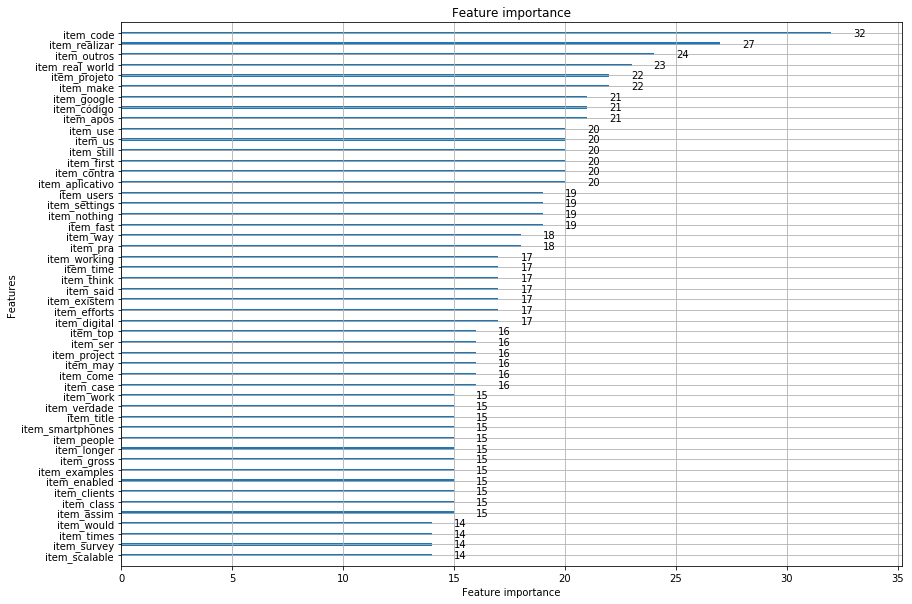

In [78]:
import matplotlib.pyplot as plt
%matplotlib inline
lgb.plot_importance(mod, max_num_features=50, figsize=(14,10))

In [79]:
test_articles_df = articles_df.loc[articles_df['contentId'].isin(interactions_test_df['contentId'])]

In [80]:
test_df_articles_tfidf, test_items_ids, test_tfidf_matrix = df_tfidf(test_articles_df)

In [81]:
test_df_user = build_users_profiles(interactions_test_df, test_tfidf_matrix, test_items_ids)

#df_interactions_test_indexed = build_interactions_profiles(test_df_user, interactions_test_indexed_df, test_df_articles_tfidf)

In [82]:
import time as time

In [83]:
class LGBMRecommender:
    #import time as time

    MODEL_NAME = 'LGBM'
    def __init__(self, modelo):
        self.modelo = modelo
        self.time = time
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, person_id, itens_to_rec, items_to_ignore, topn=10, verbose=False):

        start_time = time.time()
        test_articles_df = articles_df.loc[articles_df['contentId'].isin(itens_to_rec)]
        test_df_articles_tfidf, test_items_ids, test_tfidf_matrix = df_tfidf(test_articles_df)
        print("--- %seconds tfidf ---" % (time.time() - start_time))
        
        start_time = time.time()
        i_df = test_df_articles_tfidf
        i_df.reset_index(inplace=True, drop=True)
        
        #test_df_user vem de fora da classe
        #u = test_df_user.loc[[person_id]]
        u = train_df_user.loc[[person_id]]
        u_df = pd.concat([u]*len(itens_to_rec), ignore_index=True)
        
        data = list(test_articles_df['contentId'])
        ui_df = pd.DataFrame(data = data, columns=['contentId'])
        ui_df.insert(loc=0, column='personId', value=person_id)
        
        interactions_test_df_rec = pd.concat((ui_df,u_df,i_df),axis=1)
        #print('recommendation: ', interactions_test_df_rec[['contentId']].head(1))
        
        
        df_to_rec = interactions_test_df_rec
        df_to_rec_pred = df_to_rec.drop(['contentId','personId'], axis=1)
        print("--- %seconds BUILD DATASET ---" % (time.time() - start_time))
        #print(df_to_rec.shape)
        
        #df_to_rec_pred_columns = df_to_rec_pred.columns
        #df_aux = pd.DataFrame(index = df_to_rec_pred.index, columns = X_train_columns)

        #for c in X_train_columns:
        #    if c in df_to_rec_pred_columns:
        #        df_aux[c] = df_to_rec_pred[c]
        #            #print(df_aux[c])
        #    else:
        #        #print(c)
        #        df_aux[c] = df_aux[c].fillna(0)
        #        
        #df_to_rec_pred = df_aux
        start_time = time.time()
        #usar quando vir a resposta direto do modelo
        pred = self.modelo.predict(df_to_rec_pred)
        #pred = self.modelo.predict_proba(df_to_rec_pred)
        
        print("--- %seconds pred ---" % (time.time() - start_time))
        
        start_time = time.time()
        preds_df =  pd.DataFrame(pred, columns = ['1'])
        #preds_df =  pd.DataFrame(pred, columns = ['0','1'])
        lgbm_preds_df = pd.concat((df_to_rec[['contentId','personId']],preds_df[['1']]), axis=1)
        
        lgbm_preds_df.set_index('personId', inplace=True)
        #print("--- %seconds lgbm_preds_df ---" % (time.time() - start_time))
        #print(lgbm_preds_df)
        #print('userid ',person_id)
        
        #start_time = time.time()
        
        sorted_user_predictions = lgbm_preds_df.loc[[person_id]].sort_values(by='1',ascending=False) \
                                    .reset_index(drop=True).rename(columns={'1': 'recStrength'})
        #print(sorted_user_predictions)
        #print("--- %seconds sorted_user_predictions ---" % (time.time() - start_time))
        # Recommend the highest predicted rating movies that the user hasn't seen yet.       
        recommendations_df = sorted_user_predictions[~sorted_user_predictions['contentId'].isin(items_to_ignore)] \
                               .sort_values('recStrength', ascending = False) \
                               .head(topn)
        #print(recommendations_df)
        #start_time = time.time()
        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrength', 'contentId', 'title', 'url', 'lang']]

        #print("--- %seconds recommendations_df ---" % (time.time() - start_time))
        #print(recommendations_df)
        print("--- %seconds RESTO ---" % (time.time() - start_time))
        return recommendations_df
    
lgbm_recommender_model = LGBMRecommender(mod)

In [ ]:
%%time
print('Evaluating Light GBM model...')
lgbm_global_metrics, lgbm_detailed_results_df = model_evaluator.evaluate_model(lgbm_recommender_model)
print('\nGlobal metrics:\n%s' % lgbm_global_metrics)
lgbm_detailed_results_df.head(10)


###testar com 5 interações pra cima, estava dando erro num loc dentro do recomender

Evaluating Light GBM model...
tamanho users:  322
--- 0.1825120449066162econds tfidf ---
--- 0.053856849670410156econds BUILD DATASET ---
--- 9.08171820640564econds pred ---
--- 0.010970115661621094econds RESTO ---
--- 0.13563752174377441econds tfidf ---
--- 0.030915498733520508econds BUILD DATASET ---
--- 5.079419136047363econds pred ---
--- 0.00997304916381836econds RESTO ---
--- 0.1266944408416748econds tfidf ---
--- 0.02091383934020996econds BUILD DATASET ---
--- 3.7665603160858154econds pred ---
--- 0.009973526000976562econds RESTO ---
--- 0.14661049842834473econds tfidf ---
--- 0.03291130065917969econds BUILD DATASET ---
--- 4.443593740463257econds pred ---
--- 0.012964487075805664econds RESTO ---
--- 0.14360618591308594econds tfidf ---
--- 0.040889739990234375econds BUILD DATASET ---
--- 3.9310734272003174econds pred ---
--- 0.011967658996582031econds RESTO ---
--- 0.14749789237976074econds tfidf ---
--- 0.015623092651367188econds BUILD DATASET ---
--- 3.0999510288238525econds p

--- 2.6239407062530518econds pred ---
--- 0.00698089599609375econds RESTO ---
--- 0.08681321144104004econds tfidf ---
--- 0.01795506477355957econds BUILD DATASET ---
--- 2.491300582885742econds pred ---
--- 0.006981372833251953econds RESTO ---
--- 0.10773205757141113econds tfidf ---
--- 0.016971349716186523econds BUILD DATASET ---
--- 2.623948097229004econds pred ---
--- 0.007978200912475586econds RESTO ---
--- 0.12466883659362793econds tfidf ---
--- 0.017990827560424805econds BUILD DATASET ---
--- 2.5770881175994873econds pred ---
--- 0.007978200912475586econds RESTO ---
--- 0.10874295234680176econds tfidf ---
--- 0.019913911819458008econds BUILD DATASET ---
--- 2.555166482925415econds pred ---
--- 0.006981372833251953econds RESTO ---
--- 0.09278726577758789econds tfidf ---
--- 0.018915653228759766econds BUILD DATASET ---
--- 2.586085319519043econds pred ---
--- 0.006981849670410156econds RESTO ---
--- 0.1017611026763916econds tfidf ---
--- 0.0189516544342041econds BUILD DATASET ---
-

--- 2.3625473976135254econds pred ---
--- 0.015621662139892578econds RESTO ---
--- 0.09372687339782715econds tfidf ---
--- 0.015623092651367188econds BUILD DATASET ---
--- 2.4064993858337402econds pred ---
--- 0.006981372833251953econds RESTO ---
--- 0.09574365615844727econds tfidf ---
--- 0.017952442169189453econds BUILD DATASET ---
--- 2.5709869861602783econds pred ---
--- 0.007978677749633789econds RESTO ---
--- 0.11968088150024414econds tfidf ---
--- 0.02097797393798828econds BUILD DATASET ---
--- 2.9720776081085205econds pred ---
--- 0.0econds RESTO ---
--- 0.10384774208068848econds tfidf ---
--- 0.017951488494873047econds BUILD DATASET ---
--- 2.554502487182617econds pred ---
--- 0.006979227066040039econds RESTO ---
--- 0.12466669082641602econds tfidf ---
--- 0.01795220375061035econds BUILD DATASET ---
--- 2.8149282932281494econds pred ---
--- 0.007977962493896484econds RESTO ---
--- 0.10825467109680176econds tfidf ---
--- 0.0204012393951416econds BUILD DATASET ---
--- 2.70924305

--- 2.3241147994995117econds pred ---
--- 0.0econds RESTO ---
--- 0.10934567451477051econds tfidf ---
--- 0.01565861701965332econds BUILD DATASET ---
--- 2.2912514209747314econds pred ---
--- 0.0econds RESTO ---
--- 0.09372711181640625econds tfidf ---
--- 0.015625476837158203econds BUILD DATASET ---
--- 2.3242831230163574econds pred ---
--- 0.015621662139892578econds RESTO ---
--- 0.0951836109161377econds tfidf ---
--- 0.015624761581420898econds BUILD DATASET ---
--- 2.3173608779907227econds pred ---
--- 0.006981372833251953econds RESTO ---
--- 0.09944915771484375econds tfidf ---
--- 0.01893901824951172econds BUILD DATASET ---
--- 2.932244062423706econds pred ---
--- 0.009973764419555664econds RESTO ---
--- 0.09467434883117676econds tfidf ---
--- 0.03355121612548828econds BUILD DATASET ---
--- 2.733067512512207econds pred ---
--- 0.007979393005371094econds RESTO ---
--- 0.10892391204833984econds tfidf ---
--- 0.02190542221069336econds BUILD DATASET ---
--- 2.5531821250915527econds pred

--- 2.3969151973724365econds pred ---
--- 0.015575647354125977econds RESTO ---
--- 0.10940074920654297econds tfidf ---
--- 0.01562356948852539econds BUILD DATASET ---
--- 2.3853774070739746econds pred ---
--- 0.009973526000976562econds RESTO ---
--- 0.10970687866210938econds tfidf ---
--- 0.018989086151123047econds BUILD DATASET ---
--- 2.309035539627075econds pred ---
--- 0.015583992004394531econds RESTO ---
--- 0.10938715934753418econds tfidf ---
--- 0.03124070167541504econds BUILD DATASET ---
--- 2.926177978515625econds pred ---
--- 0.006981372833251953econds RESTO ---
--- 0.09384441375732422econds tfidf ---
--- 0.03127741813659668econds BUILD DATASET ---
--- 2.439112663269043econds pred ---
--- 0.0econds RESTO ---
--- 0.09372687339782715econds tfidf ---
--- 0.0312807559967041econds BUILD DATASET ---
--- 2.292677640914917econds pred ---
--- 0.0econds RESTO ---
--- 0.0940239429473877econds tfidf ---
--- 0.015659332275390625econds BUILD DATASET ---
--- 2.36277437210083econds pred ---


--- 2.442167043685913econds pred ---
--- 0.007978439331054688econds RESTO ---
--- 0.10201549530029297econds tfidf ---
--- 0.015659809112548828econds BUILD DATASET ---
--- 2.5361435413360596econds pred ---
--- 0.015576601028442383econds RESTO ---
--- 0.10175228118896484econds tfidf ---
--- 0.02637505531311035econds BUILD DATASET ---
--- 2.5095231533050537econds pred ---
--- 0.015620946884155273econds RESTO ---
--- 0.10733652114868164econds tfidf ---
--- 0.022939443588256836econds BUILD DATASET ---
--- 2.7990317344665527econds pred ---
--- 0.007979393005371094econds RESTO ---
--- 0.11791586875915527econds tfidf ---
--- 0.021941661834716797econds BUILD DATASET ---
--- 3.2774181365966797econds pred ---
--- 0.007979393005371094econds RESTO ---
--- 0.10870933532714844econds tfidf ---
--- 0.0048732757568359375econds BUILD DATASET ---
--- 2.9685451984405518econds pred ---
--- 0.00897526741027832econds RESTO ---
--- 0.1067507266998291econds tfidf ---
--- 0.016956329345703125econds BUILD DATASET

In [ ]:
#Best result
Global metrics:
{'modelName': 'LGBM', 'recall@5': 0.43510928961748635, 'recall@10': 0.5644808743169399}
Wall time: 33min 52s

In [ ]:
articles_df[articles_df['contentId'] == 6989198691754522425]

In [ ]:
interactions_full_df[interactions_full_df['contentId'] == 6989198691754522425]

In [ ]:
def check_base(base):
    s_types = base.dtypes
    
    s_miss = np.zeros(base.columns.size)
    j=0
    for i in base.columns:
        s_miss[j] = sum(base[i].isnull())
        j+=1

    df = pd.DataFrame({'columns':base.columns, 'types':s_types.values, 'missing':s_miss})
        
    return df[['columns','types','missing']] #ordenando a sequência das colunas

In [ ]:
articles_df.shape

In [ ]:
check_base(interactions_indexed_mode_df)

In [ ]:
articles_df.loc[articles_df['contentId']==-1868297195590431285]

## Hybrid Recommender

What if we combine Collaborative Filtering and Content-Based Filtering approaches?    
Would that provide us with more accurate recommendations?    
In fact, hybrid methods have performed better than individual approaches in many studies and have being extensively used by researchers and practioners.  
Let's build a simple hybridization method, by only multiply the CF score with the Content-Based score, and ranking by resulting score.

In [ ]:
class HybridRecommender:
    
    MODEL_NAME = 'Hybrid'
    
    def __init__(self, cb_rec_model, cf_rec_model, items_df):
        self.cb_rec_model = cb_rec_model
        self.cf_rec_model = cf_rec_model
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        #Getting the top-1000 Content-based filtering recommendations
        cb_recs_df = self.cb_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose,
                                                           topn=1000).rename(columns={'recStrength': 'recStrengthCB'})
        
        #Getting the top-1000 Collaborative filtering recommendations
        cf_recs_df = self.cf_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose, 
                                                           topn=1000).rename(columns={'recStrength': 'recStrengthCF'})
        
        #Combining the results by contentId
        recs_df = cb_recs_df.merge(cf_recs_df,
                                   how = 'inner', 
                                   left_on = 'contentId', 
                                   right_on = 'contentId')
        
        #Computing a hybrid recommendation score based on CF and CB scores
        #recs_df['recStrengthHybrid'] = recs_df['recStrengthCB'] * recs_df['recStrengthCF']
        print(min(recs_df['recStrengthCB']))
        recs_df['recStrengthHybrid'] = recs_df['recStrengthCB'] * recs_df['recStrengthCF']
        
        #Sorting recommendations by hybrid score
        recommendations_df = recs_df.sort_values('recStrengthHybrid', ascending=False).head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrengthHybrid', 'contentId', 'title', 'url', 'lang']]


        return recommendations_df
    
hybrid_recommender_model = HybridRecommender(content_based_recommender_model, cf_recommender_model, articles_df)

**It appears we have a new champion!**  
Our simple hybrid approach surpasses Content-Based filtering with its combination with Collaborative Filtering. Now we have a **Recall@5** of **43%** and **Recall@10** of **53%**

In [ ]:
print('Evaluating Hybrid model...')
hybrid_global_metrics, hybrid_detailed_results_df = model_evaluator.evaluate_model(hybrid_recommender_model)
print('\nGlobal metrics:\n%s' % hybrid_global_metrics)
hybrid_detailed_results_df.head(10)

## Comparing the methods

In [ ]:
global_metrics_df = pd.DataFrame([pop_global_metrics, cf_global_metrics, cb_global_metrics, hybrid_global_metrics]) \
                        .set_index('modelName')
global_metrics_df

In [ ]:
%matplotlib inline
ax = global_metrics_df.transpose()[['Collaborative Filtering','Content-Based','Hybrid']].plot(kind='bar', figsize=(15,8))
for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')


In [ ]:
%matplotlib inline
ax = global_metrics_df.transpose().plot(kind='bar', figsize=(15,8))
for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Testing

Let's test the best model (Hybrid) for my user.

In [ ]:
def inspect_interactions(person_id, test_set=True):
    if test_set:
        interactions_df = interactions_test_indexed_df
    else:
        interactions_df = interactions_train_indexed_df
    return interactions_df.loc[person_id].merge(articles_df, how = 'left', 
                                                      left_on = 'contentId', 
                                                      right_on = 'contentId') \
                          .sort_values('eventStrength', ascending = False)[['eventStrength', 
                                                                          'contentId',
                                                                          'title', 'url', 'lang']]

Here we see some articles I interacted in Deskdrop from train set. It can be easily observed that among my main interests are **machine learning**, **deep learning**, **artificial intelligence**, and **google cloud platform**.

In [ ]:
inspect_interactions(-1479311724257856983, test_set=False).head(20)

**The recommendations really matches my interests, as I would read all of them!**

In [ ]:
hybrid_recommender_model.recommend_items(-1479311724257856983, topn=20, verbose=True)

# Conclusion

In this notebook, we've explored and compared the main Recommender Systems techniques on [CI&T Deskdrop](https://www.kaggle.com/gspmoreira/articles-sharing-reading-from-cit-deskdrop) dataset. It could be observed that for articles recommendation, content-based filtering and a hybrid method performed better than Collaborative Filtering alone.  

There is large room for improvements of the results. Here are some tips:
- In this example, we've completely ignored the time, considering that all articles were available to be recommended to users at any time. A better approach would be to filter only articles that were available for users at a given time.
- You could leverage the available contextual information to model users preferences across time (period of day, day of week, month), location (country and state/district) and devices (browser, mobile native app).  
This contextual information can be easily incorporated in [Learn-to-Rank](https://en.wikipedia.org/wiki/Learning_to_rank) models (like XGBoost Gradient Boosting Decision Trees with ranking objective) or Logistic models (with categorical features [One-Hot encoded](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) or [Feature Hashed](https://en.wikipedia.org/wiki/Feature_hashing)). Take a look in the summary my solution shared for [Outbrain Click Prediction](https://www.kaggle.com/c/outbrain-click-prediction/discussion/27897#157215) competition. 
- Those basic techniques were used for didactic purposes. There are more advanced techniques in RecSys research community, specially advanced Matrix Factorization and Deep Learning models.  

You can know more about state-of-the-art methods published in Recommender Systems on [ACM RecSys conference](https://recsys.acm.org/).  
If you are more like practioner than researcher, you might try some Collaborative Filtering frameworks in this dataset, like [surprise](https://github.com/NicolasHug/Surprise), [mrec](https://github.com/Mendeley/mrec),  [python-recsys](https://github.com/ocelma/python-recsys) and [Spark ALS Matrix Factorization](https://spark.apache.org/docs/latest/mllib-collaborative-filtering.html) (distributed implementation for large datasets).  
Take a look in this [presentation](https://www.slideshare.net/gabrielspmoreira/discovering-users-topics-of-interest-in-recommender-systems-tdc-sp-2016) where I describe a production recommender system, focused on Content-Based Filtering and Topic Modeling techniques.

In [ ]:
from collections import defaultdict
from surprise import Reader
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import train_test_split
from surprise import accuracy





# First train an SVD algorithm on the movielens dataset.
#data = Dataset.load_builtin('ml-100k')

reader = Reader(rating_scale=(1, 4))
   
# The columns must correspond to user id, item id and ratings (in that order).
datatrain = Dataset.load_from_df(interactions_train_df[['personId', 'contentId', 'eventStrength']], reader)

datatest = Dataset.load_from_df(interactions_test_df[['personId', 'contentId', 'eventStrength']], reader)
#datatest.raw_ratings

#trainset, testset = train_test_split(data, test_size=0.30)
trainset = datatrain.construct_trainset(datatrain.raw_ratings)
algo = SVD(n_factors=15)
algo.fit(trainset)

# Than predict ratings for all pairs (u, i) that are NOT in the training set.
#testset = trainset.build_anti_testset()
testset = datatest.construct_testset(datatest.raw_ratings)
predictions = algo.test(testset)
accuracy.rmse(predictions)
#top_n = get_top_n(predictions, n=10)

# Print the recommended items for each user
#for uid, user_ratings in top_n.items():

In [ ]:
def get_top_n(predictions, n=10):
    i=0
    # First map the predictions to each user.
    top_n = defaultdict(list)
    lst =[]
    for uid, iid, true_r, est, _ in predictions:
        lst_aux = [uid,iid,est]
        #top_n[uid].append((iid, est))
        lst.append(lst_aux)
    return lst

top_n = get_top_n(predictions, n=10)

In [ ]:
top_n[:1]

In [ ]:
x = pd.DataFrame(top_n).fillna(0)


In [ ]:
x.columns = ['personId', 'contentId', 'eventStrength']

In [ ]:
np.array(x.eventStrength).size

In [ ]:
len(x['contentId'].unique().tolist())

In [ ]:
len(x['personId'].unique().tolist())

In [ ]:
x.loc[x.eventStrength == 0]

In [ ]:
x.loc[(x['personId']==-9016528795238256703) & (x['contentId']==-9192549002213406534)]

In [ ]:
pd.set_option('display.max_rows', 1000000) 

In [ ]:
#x.pivot_table(values='eventStrength', index=x['personId'].tolist(), columns=x['contentId'].tolist()).head(10)
#x.pivot_table(values='eventStrength', index=x.personId, columns='contentId').head(10)

In [ ]:
#df = x.pivot_table(values='eventStrength', index=x.personId, columns='contentId').fillna(0).transpose()
df = x.pivot_table(values='eventStrength', index=x['personId'], columns='contentId').fillna(0).transpose()

In [ ]:
df.head()

In [ ]:
class ConstantFolds():

    def __init__(self, trainset_size, n_splits=None, random_state=None,
                 shuffle=True):

        self.n_splits = 1
        self.shuffle = shuffle
        self.random_state = random_state
        self.trainset_size = trainset_size

    def split(self, data):

        indices = np.arange(len(data.raw_ratings))

        if self.shuffle:
            get_rng(self.random_state).shuffle(indices)

        raw_trainset = data.raw_ratings[:self.trainset_size]
        raw_testset = data.raw_ratings[self.trainset_size:]

        trainset = data.construct_trainset(raw_trainset)
        testset = data.construct_testset(raw_testset)

        yield trainset, testset

    def get_n_folds(self):

        return self.n_splits

In [ ]:
raw_ratings

In [ ]:
indices = np.arange(len(data.raw_ratings))

if self.shuffle:
    get_rng(self.random_state).shuffle(indices)

raw_trainset = data.raw_ratings[:self.trainset_size]
raw_testset = data.raw_ratings[self.trainset_size:]

trainset = data.construct_trainset(raw_trainset)
testset = data.construct_testset(raw_testset)

yield trainset, testset